## **Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
#import necessary libraries for performing prediction
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

## **Data Load**

In [3]:
df = pd.read_csv('../input/boston/listings.csv')
df_cal = pd.read_csv("/kaggle/input/boston/calendar.csv")

## **Price preprocessing**

*   **Object to Float**

In [4]:
price_b = []
for i in df['price']:
  price_b.append(float(i[1:].replace(',','')))
df['price'] = price_b

## **Data Preparation - Calendar data - df_cal**

In [5]:
#Extract month from dates column
df_cal['month'] = df_cal.date.apply(lambda value: value.split('-')[1])
df_cal['month'] = df_cal['month'].replace({
    '01': 'Jan',
    '02': 'Feb',
    '03': 'Mar',
    '04': 'Apr',
    '05': 'May',
    '06': 'Jun',
    '07': 'Jul',
    '08': 'Aug',
    '09': 'Sep',
    '10': 'Oct',
    '11': 'Nov',
    '12': 'Dec'
})

#Remove special character $ from price column and convert to float
#Drop rowns with na value in price column, as we have enough rows of data to gain confidence 
df_cal.dropna(axis = 0, subset = ["price"], inplace = True)
df_cal["price"] = df_cal["price"].map(lambda x: x.replace("$",'').replace(",",''), na_action = 'ignore').astype(float)

df_cal.head()

,listing_id,date,available,price,month
365,3075044,2017-08-22,t,65.0,Aug
366,3075044,2017-08-21,t,65.0,Aug
367,3075044,2017-08-20,t,65.0,Aug
368,3075044,2017-08-19,t,75.0,Aug
369,3075044,2017-08-18,t,75.0,Aug


## **Feature Engineering**

### **Q1) Which columns are influential?**

#### **Corr of Price Column**

In [6]:
price_corr = df.corr()['price'].sort_values(ascending = False).head(6)[1:]
price_corr

square_feet     0.447795
accommodates    0.437756
bedrooms        0.385298
beds            0.370013
bathrooms       0.248234
Name: price, dtype: float64

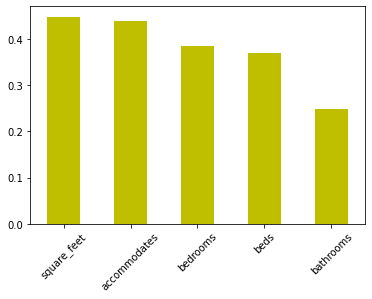

In [7]:
price_corr.plot(kind = 'bar', color = 'y');
plt.xticks(rotation=45);

#### **Result**

It seems that **area variable** is most important. (We can easily guess)

Maybe Accommodates, Bedrooms, Beds... columns are related to **area & price!**

### **Q2) Which street is most expensive?**

#### **Preprocessing Street Column**

- From street column, Extracting Street Name

In [8]:
a = list(df['street'].values)
for i in range(len(a)):
  df['street'][i] = a[i].split(',')[0]

#### **Visualization**

- Top 5 Rich Street By Our Data

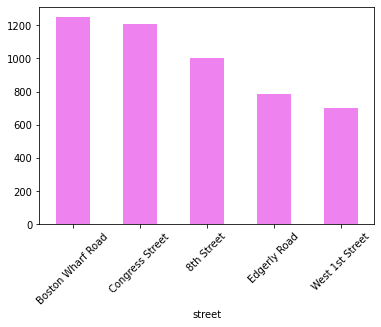

In [9]:
a = df.groupby(df['street'])['price'].mean().sort_values(ascending = False).head(5)
a.plot(kind = 'bar', color = 'violet');
plt.xticks(rotation=45);

#### **Result**

By google map, these streets are near by ocean!

Actually, I'm not living in boston(I'm korean). But I can guess that those streets are rich.

### **Q3) Relationship between Review of AIRBNB Data & Host info**

I wondered about relationship between review data and host-info!

At first, I counted positive & negative words in review data.

And merged this data with DataFrame 'df'

#### **Preprocessing**

*  **Counting Postive & Negative words in Review Data**
*  **Merging DataFrame**
*  **Filling Missing Values (-1)**

In [10]:
df_re = pd.read_csv('../input/boston/reviews.csv')
df_re

# --------------------- Positive words counting -------------------# 
ls_good = []
feature_good = ['good', 'clean', 'nice', 'great', 'Great', 'Nice', 'comfortable', 'Good', 'cool', 'Cool', 'Clean', 'enjoyed', 'bien', 'ajustado', 'cozy', 'Cozy']
for c in range(68275):
  n = 0
  try:
    for i in df_re['comments'][c].split():
      if i in feature_good:
        n += 1
      else:
        pass
  except:
    n = 0
  ls_good.append(n)

# --------------------- Negative words counting -------------------# 

  ls_bad = []
feature_bad = ['bad', 'dirty', 'uncomfortable', 'terrible', 'Bad', 'Dirty', 'Uncomfortable', 'sucio', 'malo', 'incómodo']
for c in range(68275):
  n = 0
  try:
    for i in df_re['comments'][c].split():
      if i in feature_bad:
        n += 1
      else:
        pass
  except:
    n = 0
  ls_bad.append(n)

# --------------------- Merging -------------------# 

df_re['counts_good'] = ls_good
df_re['counts_bad'] = ls_bad
df_re = df_re[['listing_id', 'counts_good', 'counts_bad']]
df_re.columns = ['id', 'counts_good', 'counts_bad']
df = pd.merge(df, df_re, on = 'id', how = 'left')

# --------------------- Filling Missing Values -------------------# 

df['counts_good'] = df['counts_good'].fillna(-1)
df['counts_bad'] = df['counts_bad'].fillna(-1)

#### **Visualization**

##### **Review values - Word counts**

100%|██████████| 7/7 [00:14<00:00,  2.02s/it]


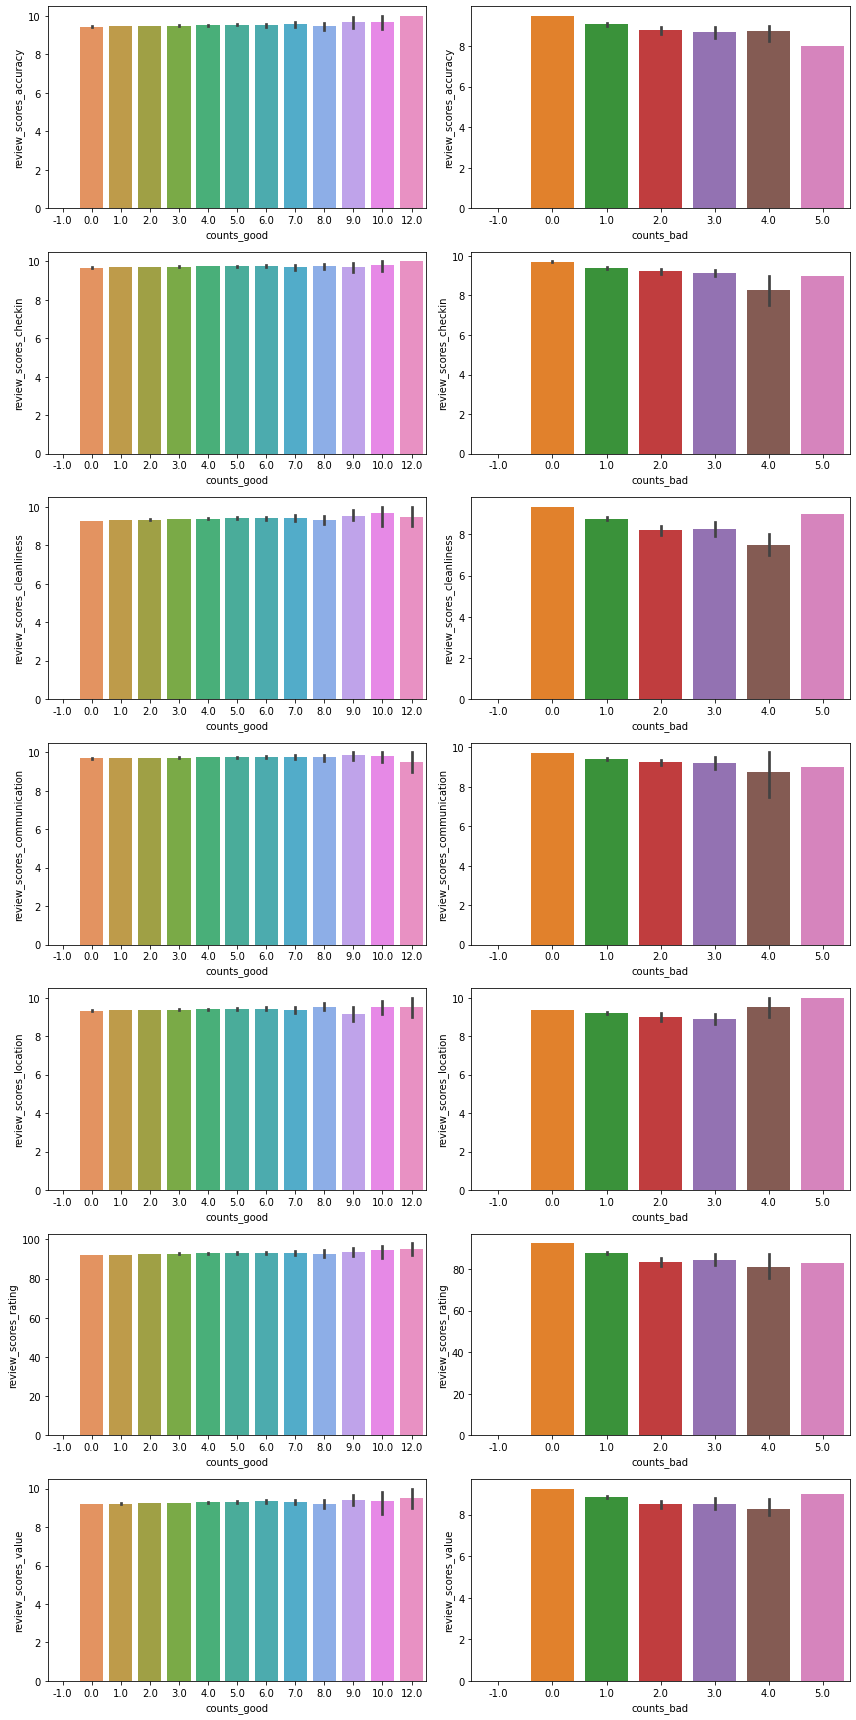

In [11]:
review_cols = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value']

fig, ax = plt.subplots(len(review_cols), 2, figsize=(12,24))

for i in tqdm(range(len(review_cols))):
  sns.barplot(df['counts_good'], df[review_cols[i]], ax = ax[i, 0])
  sns.barplot(df['counts_bad'], df[review_cols[i]], ax = ax[i, 1])

plt.tight_layout()
plt.show()

##### **Price - Word counts**

100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


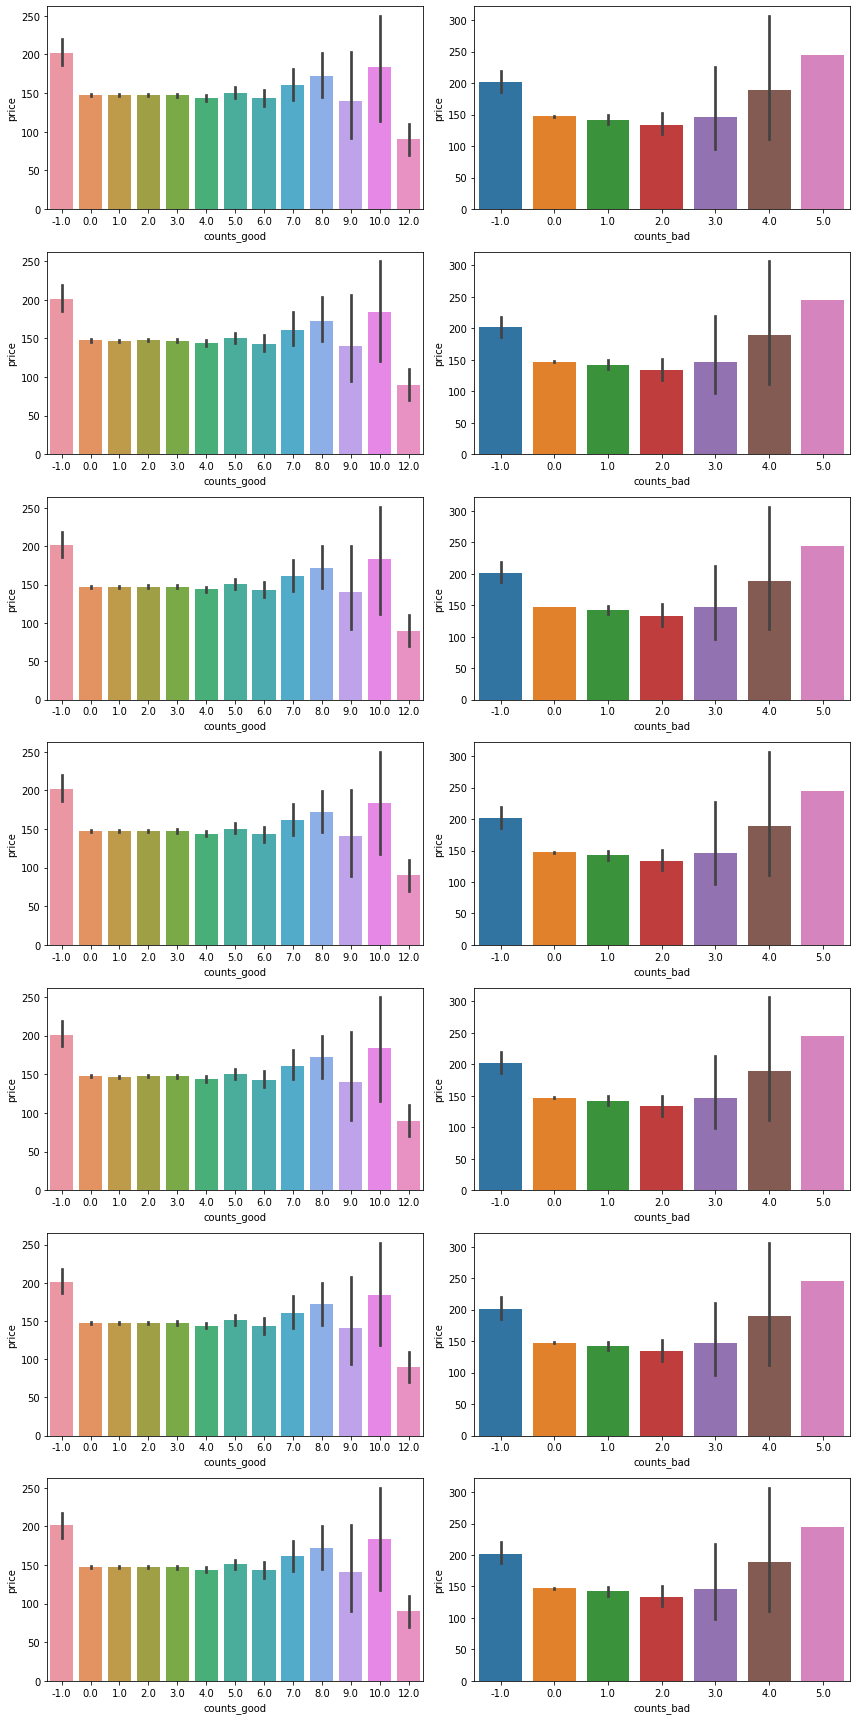

In [12]:
review_cols = ['review_scores_accuracy', 'review_scores_checkin', 'review_scores_cleanliness', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value']

fig, ax = plt.subplots(len(review_cols), 2, figsize=(12,24))

for i in tqdm(range(len(review_cols))):
  sns.barplot(df['counts_good'], df['price'], ax = ax[i, 0])
  sns.barplot(df['counts_bad'], df['price'], ax = ax[i, 1])

plt.tight_layout()
plt.show()